In [17]:
from utils import *
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the provided CSV files
outfit_data = pd.read_csv('datathon/dataset/outfit_data.csv')
product_data = pd.read_csv('datathon/dataset/product_data.csv')

In [ ]:
get_single_outfit(outfit_data, product_data, 769)

In [ ]:
plot_all_outfit_images(outfit_data, product_data)

In [ ]:
plot_outfits_for_similar_products(product_data, outfit_data, "53003736-94")

Outfit (5660) Composition Before Deleting:


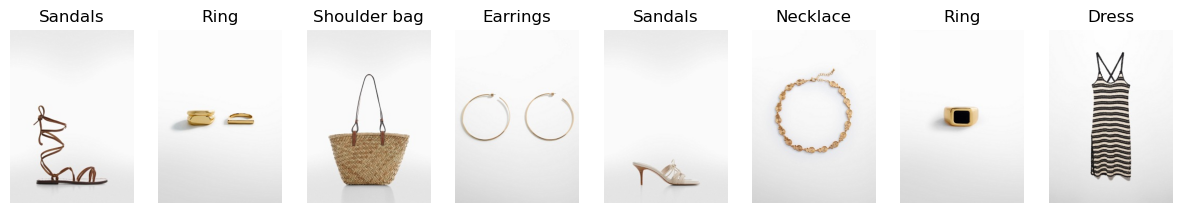

Removed Product: Shoulder bag


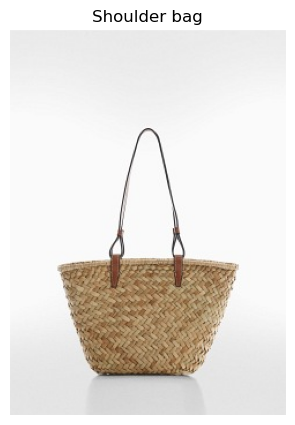

Outfit (5660) Composition Before Recommendation:


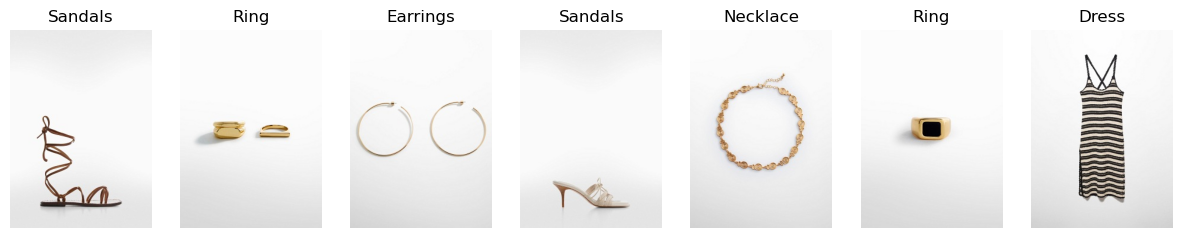


Recommended Replacement in 'Accessories - Bags' category:


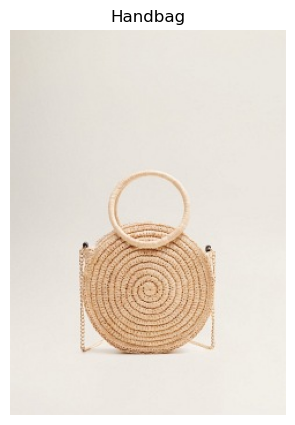


Outfit Composition After Adding Recommended Product:


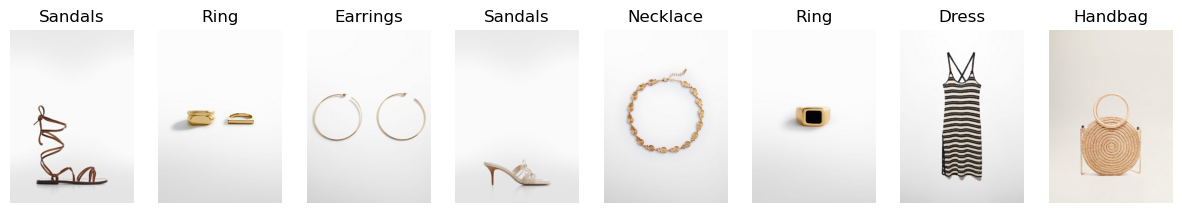

In [18]:
# Function to display product images
def display_product_images(outfit_data):
    # Display images for each product in the outfit
    fig, axes = plt.subplots(1, len(outfit_data), figsize=(15, 5))
    if len(outfit_data) == 1:
        axes = [axes]
    for ax, (index, row) in zip(axes, outfit_data.iterrows()):
        img = mpimg.imread(row['des_filename'])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{row['des_product_type']}")
    plt.show()

# Function to recommend a product to complete an outfit
def recommend_product_for_outfit(outfit_code, category_to_add, outfit_product_data):
    # Filter the outfit and the products in the desired refined category
    outfit_items = outfit_product_data[outfit_product_data['cod_outfit'] == outfit_code]
    category_products = outfit_product_data[outfit_product_data['refined_category'] == category_to_add]

    # If there are no products in the desired category, return None
    if category_products.empty:
        print(f"No products available in the '{category_to_add}' category.")
        return None

    # Creating a TF-IDF Vectorizer to analyze product descriptions
    tfidf = TfidfVectorizer(stop_words='english')
    
    # Extracting color and type descriptions from the outfit and category products
    outfit_descriptions = outfit_items['des_agrup_color_eng'] + " " + outfit_items['des_product_type']
    category_descriptions = category_products['des_agrup_color_eng'] + " " + category_products['des_product_type']

    # Fitting the vectorizer to the descriptions
    tfidf_matrix = tfidf.fit_transform(category_descriptions)
    outfit_vector = tfidf.transform(outfit_descriptions)

    # Calculating cosine similarity between the outfit and the category products
    cosine_sim = cosine_similarity(outfit_vector, tfidf_matrix)

    # Finding the best matching product
    best_match_idx = np.argmax(np.sum(cosine_sim, axis=0))
    recommended_product = category_products.iloc[best_match_idx]

    # Return the recommended product as a DataFrame
    return pd.DataFrame([recommended_product])

# Main function to run the process
def process_outfit_recommendation(product_data, outfit_product_data):
    # Randomly select an outfit
    random_outfit_code = random.choice(outfit_product_data['cod_outfit'].unique())
    outfit_items = outfit_product_data[outfit_product_data['cod_outfit'] == random_outfit_code]

    # Displaying the outfit before deleting a product
    print("Outfit ({}) Composition Before Deleting:".format(random_outfit_code))
    display_product_images(outfit_items)

    # Randomly remove a product and get its refined category
    removed_product = outfit_items.sample()
    removed_category = removed_product['refined_category'].iloc[0]
    outfit_items = outfit_items.drop(removed_product.index)

    # Displaying the removed product
    print(f"Removed Product: {removed_product['des_product_type'].iloc[0]}")
    display_product_images(removed_product)

    # Displaying the outfit before the recommendation
    print("Outfit ({}) Composition Before Recommendation:".format(random_outfit_code))
    display_product_images(outfit_items)

    # Recommend a product in the removed category
    recommended_product = recommend_product_for_outfit(random_outfit_code, removed_category, outfit_product_data)

    # If a product is recommended, display it and the updated outfit
    if recommended_product is not None:
        print(f"\nRecommended Replacement in '{removed_category}' category:")
        display_product_images(recommended_product)

        # Adding the recommended product to the outfit
        updated_outfit = pd.concat([outfit_items, recommended_product])
        print("\nOutfit Composition After Adding Recommended Product:")
        display_product_images(updated_outfit)
    else:
        print("No suitable product found for recommendation.")

# Read data
product_data = pd.read_csv('datathon/dataset/product_data.csv')
outfit_data = pd.read_csv('datathon/dataset/outfit_data.csv')

# Merging outfit data with product data to get detailed attributes of products in outfits
outfit_product_data = outfit_data.merge(product_data, on='cod_modelo_color', how='left')

# Define a function to create a refined category
def create_refined_category(row):
    return f"{row['des_product_aggregated_family']} - {row['des_product_family']}"

# Apply this function to create a new 'refined_category' column
outfit_product_data['refined_category'] = outfit_product_data.apply(create_refined_category, axis=1)


# Running the recommendation process
process_outfit_recommendation(product_data, outfit_product_data)